# Introduction to Computer Vision Project
# Pose Estimation for a Robot Manipulator
## Innopolis University, Fall 2022
---
Mirna Alnoukari, Anton Buguev, Elizaveta Kovanova

BS19-RO-01

## Data Preprocessing

### Import dataset

In [1]:
import json
import os
import shutil
import cv2
import matplotlib.pyplot as plt
import numpy as np

!unzip /content/Keypoints.v2i.yolov5pytorch.zip

Archive:  /content/Keypoints.v2i.yolov5pytorch.zip
 extracting: README.dataset.txt      
 extracting: README.roboflow.txt     
 extracting: data.yaml               
   creating: test/
   creating: test/images/
 extracting: test/images/frame0_jpg.rf.92bec8f450c3c977d6094c5af03d5586.jpg  
 extracting: test/images/frame100_jpg.rf.3d1b3d657cb6a233744162811f092623.jpg  
 extracting: test/images/frame111_jpg.rf.aac5c9efea1250bf86c8121a62614a48.jpg  
 extracting: test/images/frame113_jpg.rf.bc842acb30d6dcb9f5a3b1787cf16b3f.jpg  
 extracting: test/images/frame11_jpg.rf.22a84c423cd4c2271c3c2ffe5de0bf0d.jpg  
 extracting: test/images/frame125_jpg.rf.7ae5622dac1e114aa61dd788b3ee8f8b.jpg  
 extracting: test/images/frame137_jpg.rf.8baab4bddbfe143a3569d506e5d04079.jpg  
 extracting: test/images/frame244_jpg.rf.a423472f5899df6aeb5c9db6a506613f.jpg  
 extracting: test/images/frame250_jpg.rf.f1c2e7b24e4ba071b1533bdc932449b9.jpg  
 extracting: test/images/frame296_jpg.rf.1b0866f87fb7b822e2ac0761b8f623d1

### Display image example

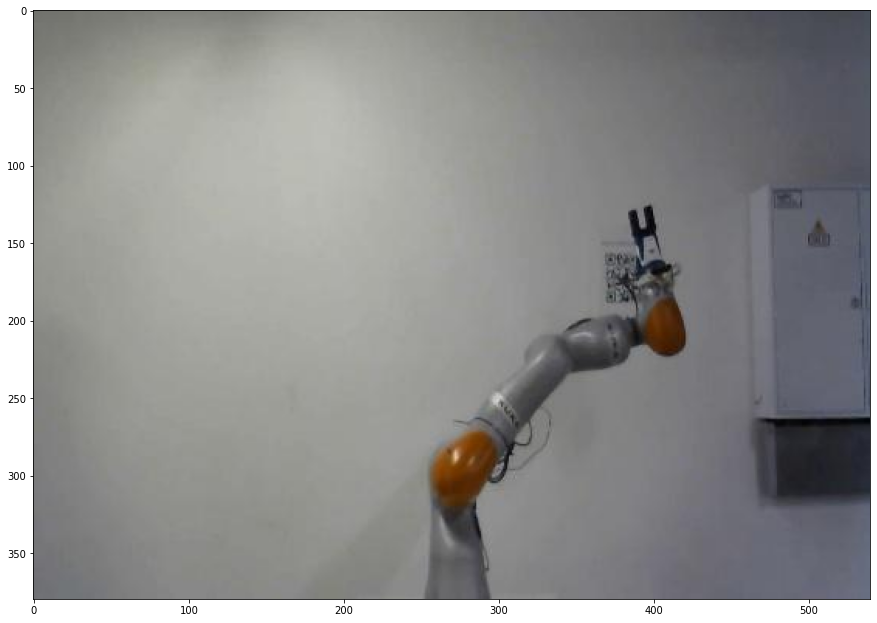

In [2]:
file_image_example = '/content/train/images/frame35_jpg.rf.36a4f3fc691f92d2eccb7de46f8dc2ca.jpg'

img = cv2.imread(file_image_example)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(15,15))
plt.imshow(img)

### Display labels example

Each displayed list contains 5 numbers:

1. **Label class** (1 - Joint, 0 - Head, 2 - Tail);
2. **Scaled $x$ coordinate** of box center, i.e., we need to multiply it by image width to get actual coordinate;
3. **Scaled $y$ coordinate** of box center, i.e., we need to multiply it by image height to get actual coordinate;
4. **Scaled box width**, i.e., we need to multiply it by image width to get actual box width;
5. **Scaled box height**, i.e., we need to multiply it by image height to get actual box height.

In [3]:
file_labels_example = '/content/train/labels/frame35_jpg.rf.36a4f3fc691f92d2eccb7de46f8dc2ca.txt'

labels_arr = []
with open(file_labels_example) as f:
    all_labels = f.readlines()
    for label in all_labels:
        labels_arr.append([int(label.split()[0])] + [round(float(el), 7) for el in label.split()[1:]])
print(labels_arr)
for idx, label in enumerate(labels_arr):
    print("Rectangle {}:".format(idx+1), label)

[[1, 0.5136667, 0.7798421, 0.0779074, 0.1315526], [2, 0.4874444, 0.8225526, 0.0089815, 0.0132895], [0, 0.5408519, 0.7217368, 0.0073704, 0.009], [1, 0.755037, 0.5387105, 0.0518704, 0.1002368], [0, 0.755037, 0.4957895, 0.0077222, 0.0094737], [2, 0.7646111, 0.5799474, 0.0078704, 0.0092368]]
Rectangle 1: [1, 0.5136667, 0.7798421, 0.0779074, 0.1315526]
Rectangle 2: [2, 0.4874444, 0.8225526, 0.0089815, 0.0132895]
Rectangle 3: [0, 0.5408519, 0.7217368, 0.0073704, 0.009]
Rectangle 4: [1, 0.755037, 0.5387105, 0.0518704, 0.1002368]
Rectangle 5: [0, 0.755037, 0.4957895, 0.0077222, 0.0094737]
Rectangle 6: [2, 0.7646111, 0.5799474, 0.0078704, 0.0092368]


## Convert scaled coordinates, width and height into actual coordinates, width and height respectively.

In [4]:
keypoint_names = ['Head', 'Tail']

# For each label the information about bounding box is the most important
# Since we have wrong order of classes inside each label, we need to reconfigure it as well
# We keep head with the same class number while changing the tail class number
upd_classes = {0:0, 2:1}

def converter(file_labels, file_image, keypoint_names):

    img = cv2.imread(file_image)
    img_w, img_h = img.shape[1], img.shape[0] # Image width and height
    
    labels_arr = []
    # Read all labels from file
    with open(file_labels) as f:
        all_labels = f.readlines()
        for label in all_labels:
            label_split = label.split()
            labels_arr.append([int(label_split[0])] + [round(float(el), 5) for el in label_split[1:]])
    
    bboxes = [] # Bounding boxes for joints
    keypoints = [] # Coordinates of keypoints, i.e., heads and tails

    for label in labels_arr:
        # If current label class is 1, it is joint and we need to find corresponding bounding box,
        # i.e., multiply scaled coordinates and dimensions by image widht and height respectively
        # to find coordinates of top left and bottom right corners
        if label[0] == 1:
            x_c, y_c, w, h = round(label[1] * img_w), round(label[2] * img_h), \
                            round(label[3] * img_w), round(label[4] * img_h)
            top_left_x, top_left_y, bottom_right_x, bottom_right_y = round(x_c - w/2), round(y_c - h/2), \
                                                                    round(x_c + w/2), round(y_c + h/2)
            bboxes.append([top_left_x, top_left_y, bottom_right_x, bottom_right_y])

        # Otherwise, just find the real senter of a keypoint and assign updated class number
        else:
            kp_class, x_c, y_c = upd_classes[label[0]], round(label[1] * img_w), round(label[2] * img_h)
            keypoints.append([kp_class, x_c, y_c])

    # For this moment keypoints may be in wrong order and we need to restore it,
    # i.e., for each bounding box we find corresponding keypoints
    keypoints_sorted = [] # list of sorted keypoints
    for bbox_idx, bbox in enumerate(bboxes):
        top_left_x, top_left_y, bottom_right_x, bottom_right_y = bbox[0], bbox[1], \
                                                                  bbox[2], bbox[3] # corners of bounding box
        bbox_keypoints = []
        for kp in keypoints:
            kp_class, kp_x, kp_y = kp[0], kp[1], kp[2] # keypoint class and coordinates
            # If the current keypoint is located inside the bounding box, then it belongs to it, so we save it
            if top_left_x < kp_x < bottom_right_x and top_left_y < kp_y < bottom_right_y:
                bbox_keypoints.extend([[kp_x, kp_y, 1]]) # add keypoint to the current bounding box
                # keypoints have 1 at the end which means they are all visible
        keypoints_sorted.append(bbox_keypoints) # Save keypoints
    return bboxes, keypoints_sorted


### Show example of converting labels' information

In [5]:
bboxes, keypoints_sorted = converter(file_labels_example, file_image_example, keypoint_names)

print("Bboxes:", bboxes)
print("Keypoints:", keypoints_sorted)

Bboxes: [[256, 271, 298, 321], [394, 186, 422, 224]]
Keypoints: [[[263, 313, 1], [292, 274, 1]], [[408, 188, 1], [413, 220, 1]]]


## Function to save converted bounding boxes and keypoints into JSON file

In [6]:
def dump2json(bboxes, keypoints_sorted, file_json):
    annotations = {}
    annotations['bboxes'], annotations['keypoints'] = bboxes, keypoints_sorted
    with open(file_json, "w") as f:
        json.dump(annotations, f)

### Prepare train and test data, i.e. read all images and their labels, convert lables into image coordinates and save data into JSON files

In [7]:
IMAGES_TRAIN = '/content/train/images'
LABELS_TRAIN = '/content/train/labels'
ANNOTATIONS_TRAIN = '/content/train/annotations'

IMAGES_TEST = '/content/test/images'
LABELS_TEST = '/content/test/labels'
ANNOTATIONS_TEST = '/content/test/annotations'

# Create directories of not done, otherwise remove them and create empty folders
if not os.path.isdir(ANNOTATIONS_TRAIN):
  os.mkdir(ANNOTATIONS_TRAIN)
else:
  shutil.rmtree(ANNOTATIONS_TRAIN)
  os.mkdir(ANNOTATIONS_TRAIN)
if not os.path.isdir(ANNOTATIONS_TEST):
  os.mkdir(ANNOTATIONS_TEST)
else:
  shutil.rmtree(ANNOTATIONS_TEST)
  os.mkdir(ANNOTATIONS_TEST)


files_names_train = [file.split('.jpg')[0] for file in os.listdir(IMAGES_TRAIN)] # All train images

for file in files_names_train:
    file_labels = os.path.join(LABELS_TRAIN, file + ".txt") # read labels data
    file_image = os.path.join(IMAGES_TRAIN, file + ".jpg") # read image
    bboxes, keypoints_sorted = converter(file_labels, file_image, keypoint_names) # convert coordinates
    dump2json(bboxes, keypoints_sorted, os.path.join(ANNOTATIONS_TRAIN, file + '.json')) # save into JSON file


files_names_test = [file.split('.jpg')[0] for file in os.listdir(IMAGES_TEST)] # All test images

for file in files_names_test:
    file_labels = os.path.join(LABELS_TEST, file + ".txt") # read labels data
    file_image = os.path.join(IMAGES_TEST, file + ".jpg") # read image
    bboxes, keypoints_sorted = converter(file_labels, file_image, keypoint_names) # convert coordinates
    dump2json(bboxes, keypoints_sorted, os.path.join(ANNOTATIONS_TEST, file + '.json')) # save into JSON file

## Training

### Import necessary libraries

In [8]:
import os, json, cv2, numpy as np, matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.transforms import functional as F

import albumentations as A 

### Function to apply random transformation to the image, i.e. rotate and image by $90^{\circ}$ random number of times and randomly change brightness and contrast

In [9]:
def train_transform():
    return A.Compose([
        A.Sequential([
            A.RandomRotate90(p=1), # Random rotation of an image by 90 degrees random number of times
            A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, brightness_by_max=True, always_apply=False, p=1), # Random change of brightness & contrast
        ], p=1)
    ],
    keypoint_params=A.KeypointParams(format='xy'),
    bbox_params=A.BboxParams(format='pascal_voc', label_fields=['bboxes_labels'])
    )

### Custom dataset

In [10]:
class ClassDataset(Dataset):
    def __init__(self, root, transform=None, demo=False):                
        self.root = root # files directory
        self.transform = transform # applied transformation
        self.demo = demo # set true if we need to keep original and transformed images
        self.imgs_files = sorted(os.listdir(os.path.join(root, "images"))) # images directory
        self.annotations_files = sorted(os.listdir(os.path.join(root, "annotations"))) # annotations directory
    
    def __getitem__(self, idx):
        # Open requested image 
        img_path = os.path.join(self.root, "images", self.imgs_files[idx])
        img_original = cv2.imread(img_path)
        img_original = cv2.cvtColor(img_original, cv2.COLOR_BGR2RGB)        
        
        # Open corresponding annotations
        annotations_path = os.path.join(self.root, "annotations", self.annotations_files[idx])
        with open(annotations_path) as f:
            data = json.load(f)
            bboxes_original = data['bboxes']
            keypoints_original = data['keypoints']
            
            # All bounding boxes are for joint
            bboxes_labels_original = ['Joint' for _ in bboxes_original]            

        # If transformations is specified, we apply it fot this image
        if self.transform:
            # Flatten keypoints array, i.e. 
            # instead of double list create single list of x and y coordinates only for all keypoints
            keypoints_original_flattened = [kp_data[0:2] for keypoint in keypoints_original for kp_data in keypoint]
            
            # Apply augmentations
            transformed = self.transform(image=img_original, bboxes=bboxes_original, bboxes_labels=bboxes_labels_original, keypoints=keypoints_original_flattened)
            img = transformed['image']
            bboxes = transformed['bboxes']
            
            # Unflatten keypoints coordinates, i.e. from single list of pairs of x and y coordinates,
            # we need to create double list with such pairs
            keypoints_transformed_unflattened = np.reshape(np.array(transformed['keypoints']), (-1,2,2)).tolist()

            # For each unflattened keypoint, add corresponding visibility value from initial data
            keypoints = []
            for o_idx, obj in enumerate(keypoints_transformed_unflattened): # Iterating over objects
                obj_keypoints = []
                for k_idx, kp in enumerate(obj): # Iterating over keypoints in each object
                    # kp - coordinates of keypoint
                    # keypoints_original[o_idx][k_idx][2] - original visibility of keypoint
                    obj_keypoints.append(kp + [keypoints_original[o_idx][k_idx][2]])
                keypoints.append(obj_keypoints)
        
        else:
            img, bboxes, keypoints = img_original, bboxes_original, keypoints_original        
        
        # Convert everything into a torch tensor        
        bboxes_original = torch.as_tensor(bboxes_original, dtype=torch.float32)
        target_original = {}
        target_original["boxes"] = bboxes_original
        target_original["labels"] = torch.as_tensor([1 for _ in bboxes_original], dtype=torch.int64) # all objects are joints
        target_original["image_id"] = torch.tensor([idx])
        target_original["area"] = np.abs(bboxes_original[:, 3] - bboxes_original[:, 1]) * np.abs(bboxes_original[:, 2] - bboxes_original[:, 0])
        target_original["iscrowd"] = torch.zeros(len(bboxes_original), dtype=torch.int64)
        target_original["keypoints"] = torch.as_tensor(keypoints_original, dtype=torch.float32)        
        img_original = F.to_tensor(img_original)
        
        bboxes = torch.as_tensor(bboxes, dtype=torch.float32)       
        target = {}
        target["boxes"] = bboxes
        target["labels"] = torch.as_tensor([1 for _ in bboxes], dtype=torch.int64) # all objects are joints
        target["image_id"] = torch.tensor([idx])
        target["area"] = np.abs(bboxes[:, 3] - bboxes[:, 1]) * np.abs(bboxes[:, 2] - bboxes[:, 0])
        target["iscrowd"] = torch.zeros(len(bboxes), dtype=torch.int64)
        target["keypoints"] = torch.as_tensor(keypoints, dtype=torch.float32)        
        img = F.to_tensor(img)

        if self.demo:
            return img, target, img_original, target_original
        else:
            return img, target
    
    def __len__(self):
        return len(self.imgs_files)

### Display example of train dataset

In [11]:
import transforms, utils, engine, train
from utils import collate_fn
from engine import train_one_epoch, evaluate

KEYPOINTS_FOLDER_TRAIN = '/content/train'
dataset = ClassDataset(KEYPOINTS_FOLDER_TRAIN, transform=train_transform(), demo=True)
data_loader = DataLoader(dataset, batch_size=1, shuffle=True, collate_fn=collate_fn)

iterator = iter(data_loader)
batch = next(iterator)

print("Original targets:\n", batch[3], "\n\n")
print("Transformed targets:\n", batch[1])

Original targets:
 ({'boxes': tensor([[256., 272., 298., 322.],
        [394., 185., 422., 223.]]), 'labels': tensor([1, 1]), 'image_id': tensor([38]), 'area': tensor([2100., 1064.]), 'iscrowd': tensor([0, 0]), 'keypoints': tensor([[[293., 275.,   1.],
         [265., 315.,   1.]],

        [[406., 188.,   1.],
         [414., 221.,   1.]]])},) 


Transformed targets:
 ({'boxes': tensor([[ 58., 256., 108., 298.],
        [157., 394., 195., 422.]]), 'labels': tensor([1, 1]), 'image_id': tensor([38]), 'area': tensor([2100., 1064.]), 'iscrowd': tensor([0, 0]), 'keypoints': tensor([[[104., 293.,   1.],
         [ 64., 265.,   1.]],

        [[191., 406.,   1.],
         [158., 414.,   1.]]])},)


### Install additional library

In [12]:
pip install pycocotools

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Function to visualize images alongside original image

In [13]:
keypoints_classes_ids2names = {0: 'Head', 1: 'Tail'}

def visualize(image, bboxes, keypoints, image_original=None, bboxes_original=None, keypoints_original=None):
    fontsize = 18

    # Draw rectangle for each bounding box
    for bbox in bboxes:
        start_point = (bbox[0], bbox[1])
        end_point = (bbox[2], bbox[3])
        image = cv2.rectangle(image.copy(), start_point, end_point, (0,255,0), 2)
    
    # Draw circle for each keypoint and write corresponding class
    for kps in keypoints:
        for idx, kp in enumerate(kps):
            image = cv2.circle(image.copy(), tuple(kp), 3, (255,0,0), -5)
            image = cv2.putText(image.copy(), " " + keypoints_classes_ids2names[idx], tuple(kp), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,0,0), 1)

    # If original image is not provided, just show provided image
    if image_original is None and keypoints_original is None:
        plt.figure(figsize=(40,40))
        plt.axis('off')
        plt.imshow(image)

    # Otherwise draw rectangles and circles on original image
    else:
        for bbox in bboxes_original:
            start_point = (bbox[0], bbox[1])
            end_point = (bbox[2], bbox[3])
            image_original = cv2.rectangle(image_original.copy(), start_point, end_point, (0,255,0), 2)
        
        for kps in keypoints_original:
            for idx, kp in enumerate(kps):
                image_original = cv2.circle(image_original, tuple(kp), 3, (255,0,0), -5)
                image_original = cv2.putText(image_original, " " + keypoints_classes_ids2names[idx], tuple(kp), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,0,0), 1)

        f, ax = plt.subplots(1, 2, figsize=(40, 20))

        ax[0].axis('off')
        ax[0].imshow(image_original)
        ax[0].set_title('Original image', fontsize=fontsize)

        ax[1].axis('off')
        ax[1].imshow(image)
        ax[1].set_title('Transformed image', fontsize=fontsize)

### Display an example of transformed image

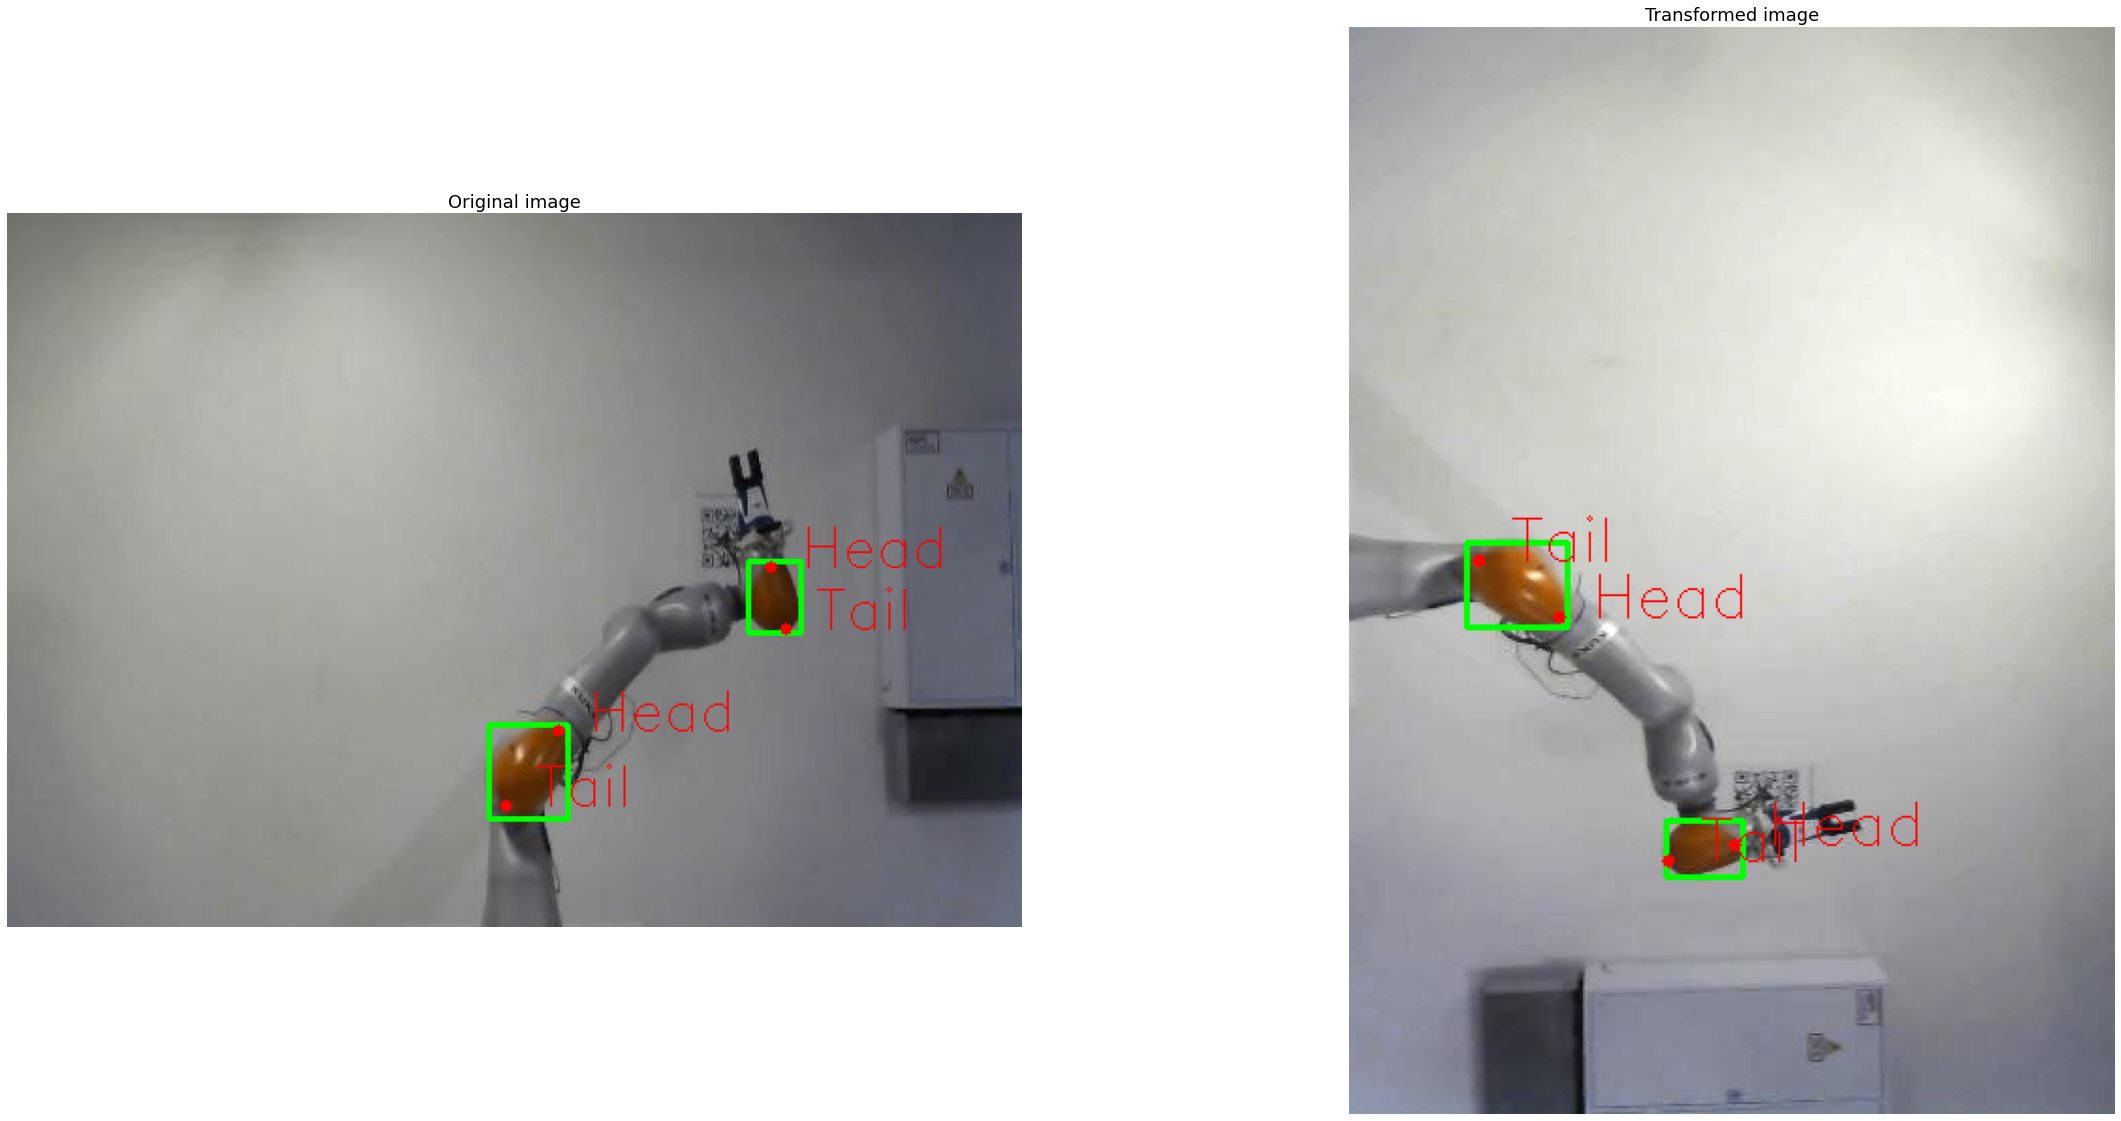

In [14]:
image = (batch[0][0].permute(1,2,0).numpy() * 255).astype(np.uint8) # take transformed image from dataset
bboxes = batch[1][0]['boxes'].detach().cpu().numpy().astype(np.int32).tolist() # take corresponding bounding boxes

# Create list of corresponding keypoints
keypoints = []
for kps in batch[1][0]['keypoints'].detach().cpu().numpy().astype(np.int32).tolist():
    keypoints.append([kp[:2] for kp in kps])

# Do the same for original image
image_original = (batch[2][0].permute(1,2,0).numpy() * 255).astype(np.uint8)
bboxes_original = batch[3][0]['boxes'].detach().cpu().numpy().astype(np.int32).tolist()

keypoints_original = []
for kps in batch[3][0]['keypoints'].detach().cpu().numpy().astype(np.int32).tolist():
    keypoints_original.append([kp[:2] for kp in kps])

# Call function to show result
visualize(image, bboxes, keypoints, image_original, bboxes_original, keypoints_original)

### Function to create model

In [15]:
def get_model(num_keypoints, weights_path=None):    
    anchor_generator = AnchorGenerator(sizes=(32, 64, 128, 256, 512), aspect_ratios=(0.25, 0.5, 0.75, 1.0, 2.0, 3.0, 4.0))
    model = torchvision.models.detection.keypointrcnn_resnet50_fpn(pretrained=False,
                                                                   pretrained_backbone=True,
                                                                   num_keypoints=num_keypoints,
                                                                   num_classes = 2, # Background is the first class, object is the second class
                                                                   rpn_anchor_generator=anchor_generator)

    if weights_path:
        state_dict = torch.load(weights_path)
        model.load_state_dict(state_dict)        
        
    return model

### Create datasets and model

In [16]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

KEYPOINTS_FOLDER_TRAIN = '/content/train'
KEYPOINTS_FOLDER_TEST = '/content/test'

dataset_train = ClassDataset(KEYPOINTS_FOLDER_TRAIN, transform=train_transform(), demo=False)
dataset_test = ClassDataset(KEYPOINTS_FOLDER_TEST, transform=None, demo=False)

data_loader_train = DataLoader(dataset_train, batch_size=3, shuffle=True, collate_fn=collate_fn)
data_loader_test = DataLoader(dataset_test, batch_size=1, shuffle=False, collate_fn=collate_fn)

model = get_model(num_keypoints = 2)
model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.001, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.3)
num_epochs = 50

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained_backbone' is deprecated since 0.13 and will be removed in 0.15, please use 'weights_backbone' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight

  0%|          | 0.00/97.8M [00:00<?, ?B/s]

### Run training

In [17]:
train_loss = []

for epoch in range(num_epochs):
    metric_logger = train_one_epoch(model, optimizer, data_loader_train, device, epoch, print_freq=1000)
    train_loss.append(metric_logger.loss.value)
    lr_scheduler.step()
    coco_evaluator = evaluate(model, data_loader_test, device)
    
# Save model weights after training
torch.save(model.state_dict(), '/content/weights')

Epoch: [0]  [ 0/29]  eta: 0:03:32  lr: 0.000037  loss: 9.6573 (9.6573)  loss_classifier: 0.6958 (0.6958)  loss_box_reg: 0.1432 (0.1432)  loss_keypoint: 8.1109 (8.1109)  loss_objectness: 0.6991 (0.6991)  loss_rpn_box_reg: 0.0083 (0.0083)  time: 7.3404  data: 0.0357  max mem: 2892
Epoch: [0]  [28/29]  eta: 0:00:01  lr: 0.001000  loss: 8.8976 (9.0746)  loss_classifier: 0.2401 (0.3652)  loss_box_reg: 0.0883 (0.0880)  loss_keypoint: 7.9135 (7.9228)  loss_objectness: 0.6850 (0.6857)  loss_rpn_box_reg: 0.0130 (0.0129)  time: 0.9315  data: 0.0245  max mem: 4878
Epoch: [0] Total time: 0:00:33 (1.1457 s / it)
creating index...
index created!
Test:  [ 0/20]  eta: 0:00:05  model_time: 0.2216 (0.2216)  evaluator_time: 0.0222 (0.0222)  time: 0.2521  data: 0.0075  max mem: 4878
Test:  [19/20]  eta: 0:00:00  model_time: 0.2216 (0.2220)  evaluator_time: 0.0134 (0.0140)  time: 0.2433  data: 0.0065  max mem: 4878
Test: Total time: 0:00:04 (0.2434 s / it)
Averaged stats: model_time: 0.2216 (0.2220)  evalu

### Save pretrained model

In [ ]:
torch.save(model, '/content/model.pt')

## Model evaluation

### Display training loss

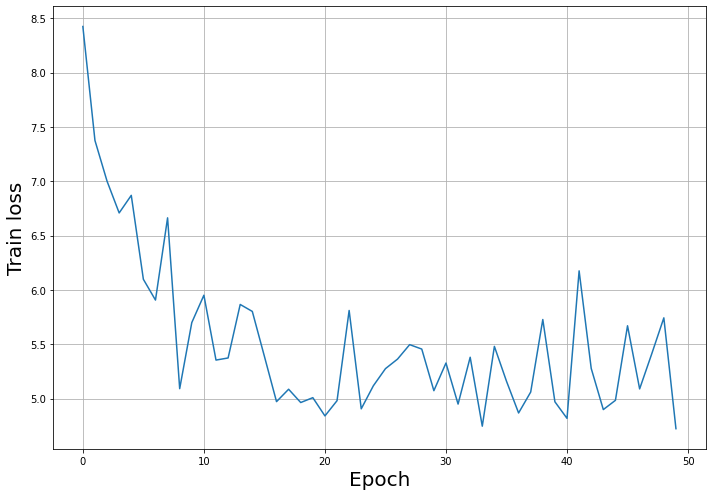

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10,7))

ax.plot(np.arange(num_epochs), np.array(train_loss))
ax.set_xlabel("Epoch", fontsize=20)
ax.set_ylabel("Train loss", fontsize=20)
ax.grid()
plt.tight_layout()

### Display model prediction results

In [18]:
# Take images from dataset
iterator = iter(data_loader_test)
for _ in range(2):
  images, targets = next(iterator)
images = list(image.to(device) for image in images)

# Generate predictions
with torch.no_grad():
    model.to(device)
    model.eval()
    output = model(images)

print("Predictions: \n", output)

Predictions: 
 [{'boxes': tensor([[368.7583, 133.8440, 393.7138, 179.4789],
        [354.7444, 147.3611, 398.3179, 165.8205],
        [256.4182, 270.2415, 303.9234, 320.6451],
        [387.3529, 143.5687, 393.5747, 171.8802],
        [352.3550, 153.9903, 394.4930, 171.3242],
        [367.4221, 155.5215, 393.4890, 167.7032],
        [271.2627, 271.8518, 289.7647, 320.3450],
        [373.9344, 147.6921, 393.9432, 158.4318],
        [253.4309, 286.6142, 301.8361, 306.3124],
        [366.6441, 150.2969, 393.0140, 162.8515],
        [379.8861, 144.5587, 386.7748, 171.9512],
        [382.5342, 145.9652, 393.7409, 167.6945],
        [256.8293, 279.2546, 306.7128, 299.4011],
        [254.8130, 287.8143, 291.7891, 321.4591],
        [376.7001, 146.9060, 384.3869, 170.8720],
        [265.4404, 269.8477, 282.1952, 325.9086],
        [258.3785, 278.8204, 289.0611, 311.8352],
        [377.2693, 148.4898, 390.1940, 169.4397],
        [259.4170, 272.6854, 309.7400, 292.1803],
        [351.5434, 137.3

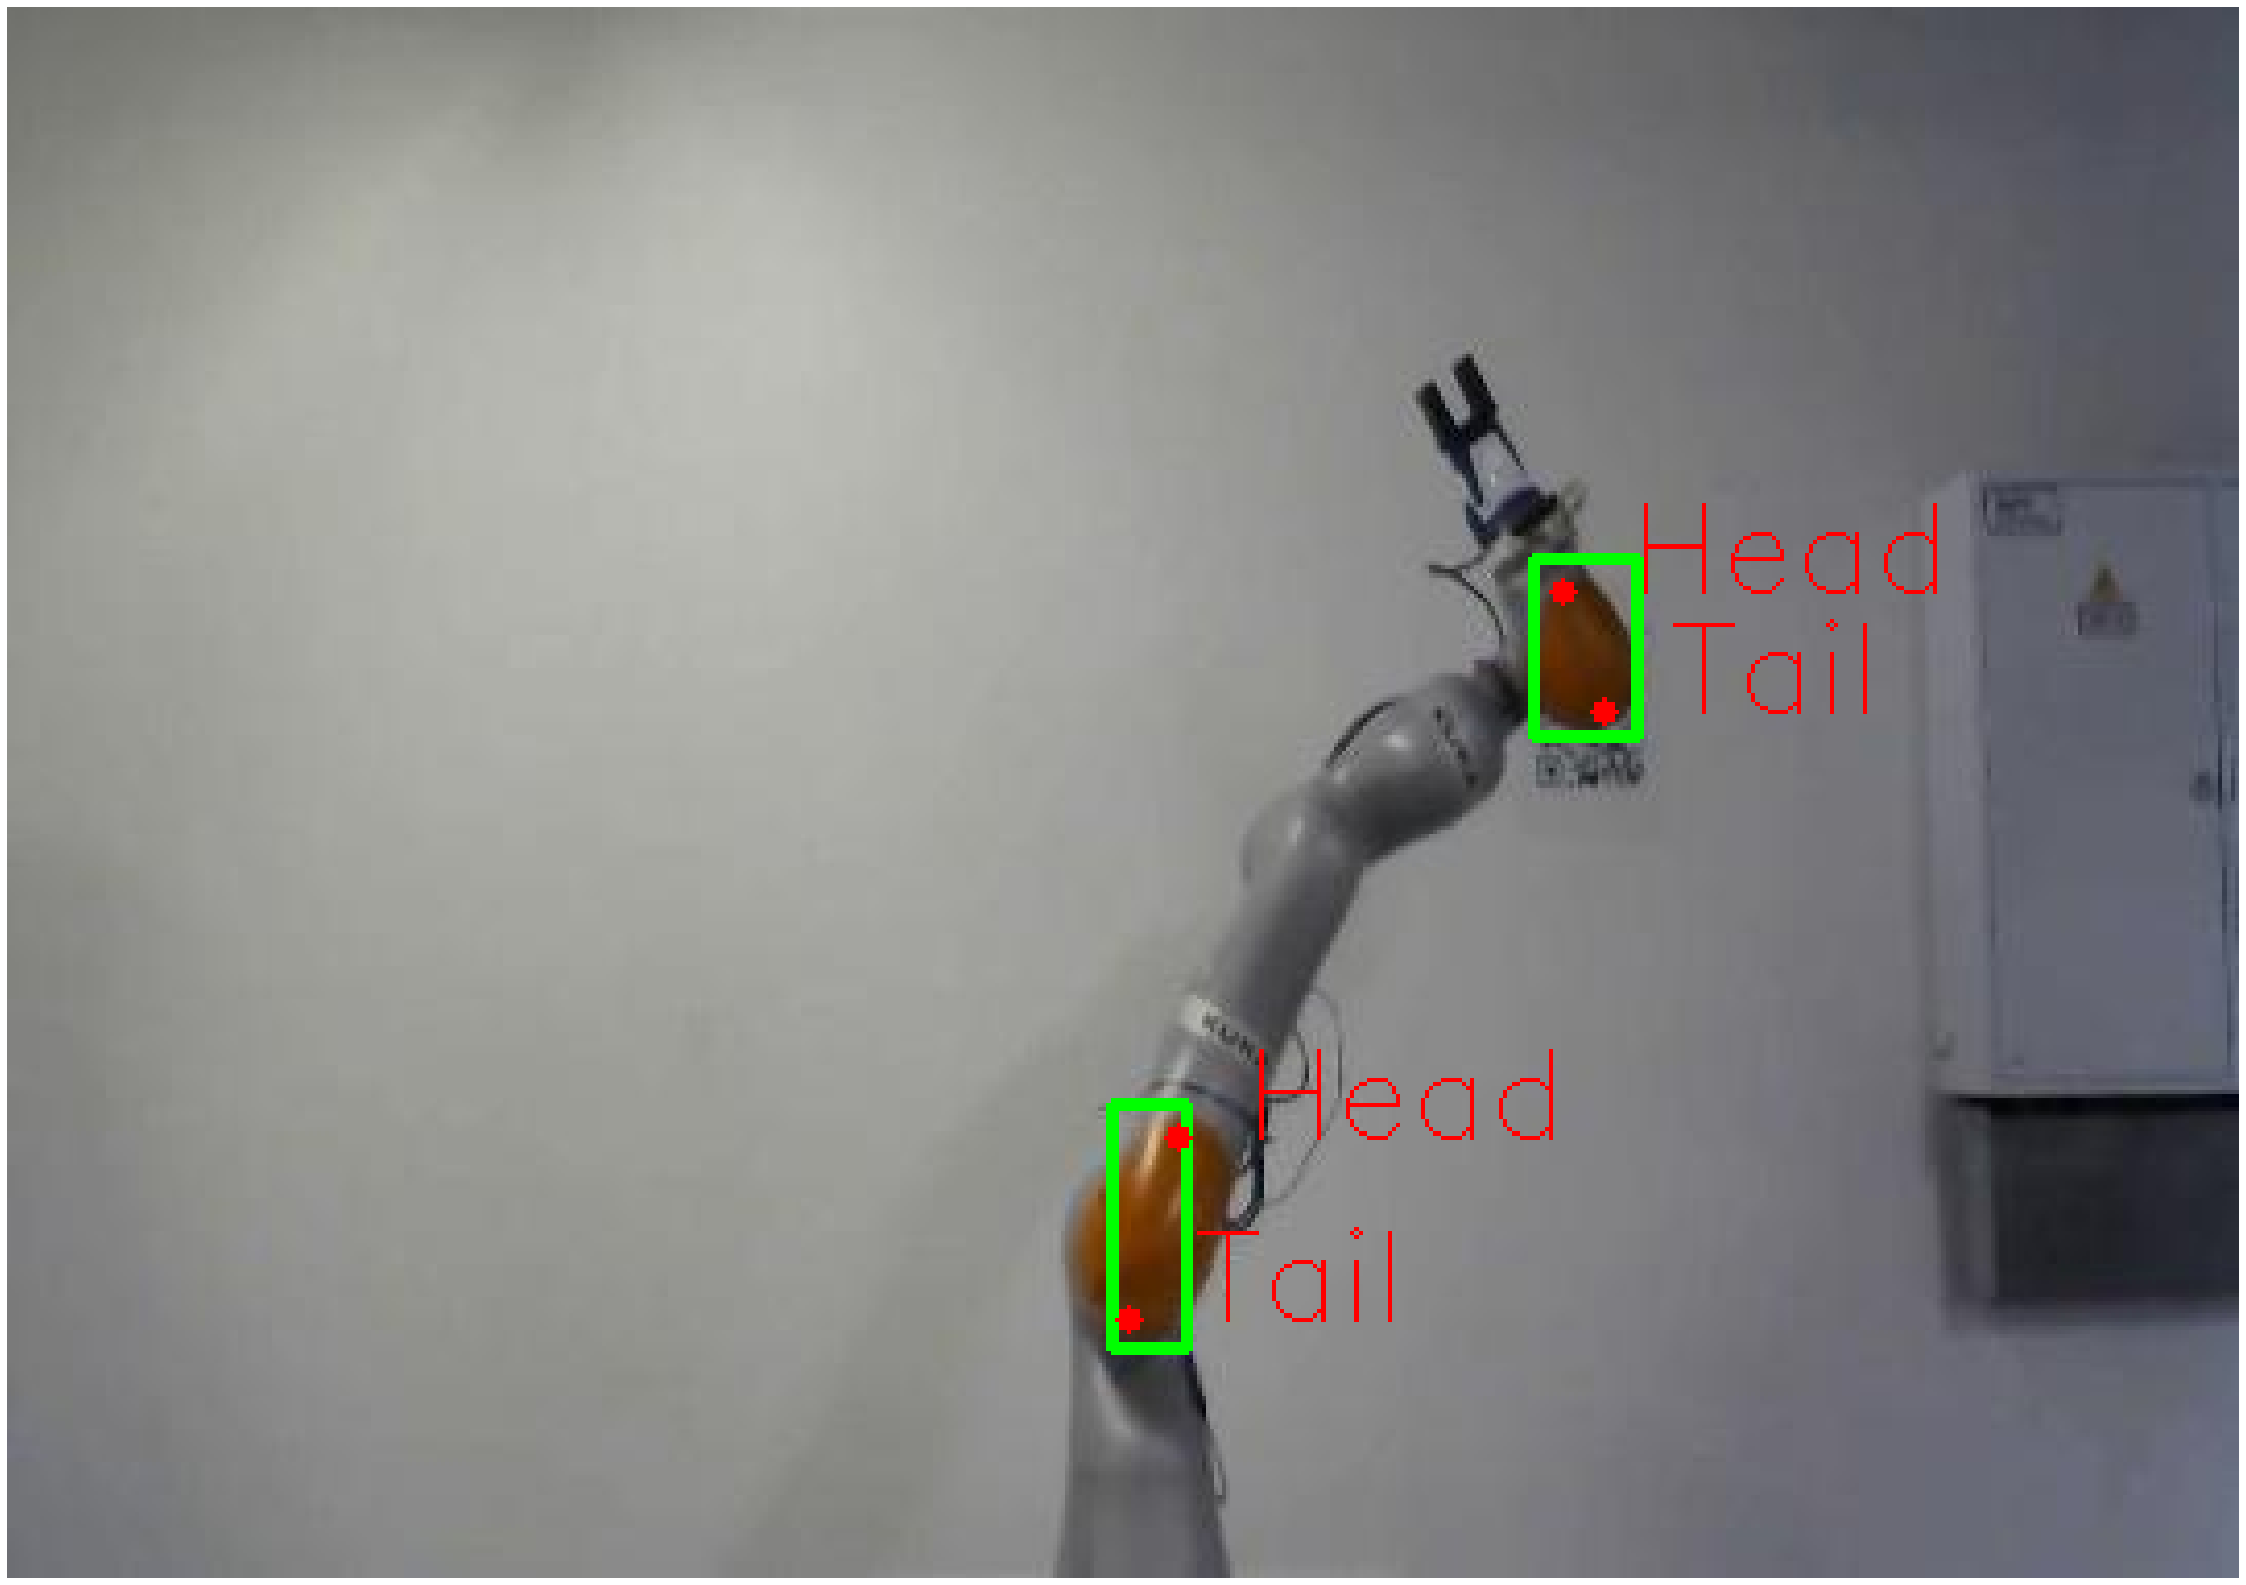

In [ ]:
# Take one of predicted images
image2 = (images[0].permute(1,2,0).detach().cpu().numpy() * 255).astype(np.uint8)
# Get prediction scores
scores = output[0]['scores'].detach().cpu().numpy()

# Find indices of elements with score > 0.2
high_scores_idxs = np.where(scores > 0.2)[0].tolist()
# Find indicess of boxes after applying Non-Maximum Suppression (NMS)
post_nms_idxs = torchvision.ops.nms(output[0]['boxes'][high_scores_idxs], output[0]['scores'][high_scores_idxs], 0.1).cpu().numpy()

# Find bounding boxes using thresholed indices
bboxes = []
for bbox in output[0]['boxes'][high_scores_idxs][post_nms_idxs].detach().cpu().numpy():
    bboxes.append(list(map(int, bbox.tolist())))

# Find keypoints using thresholed indices
keypoints = []
for kps in output[0]['keypoints'][high_scores_idxs][post_nms_idxs].detach().cpu().numpy():
    keypoints.append([list(map(int, kp[:2])) for kp in kps])

# Call function to visualize result
visualize(image2, bboxes, keypoints)

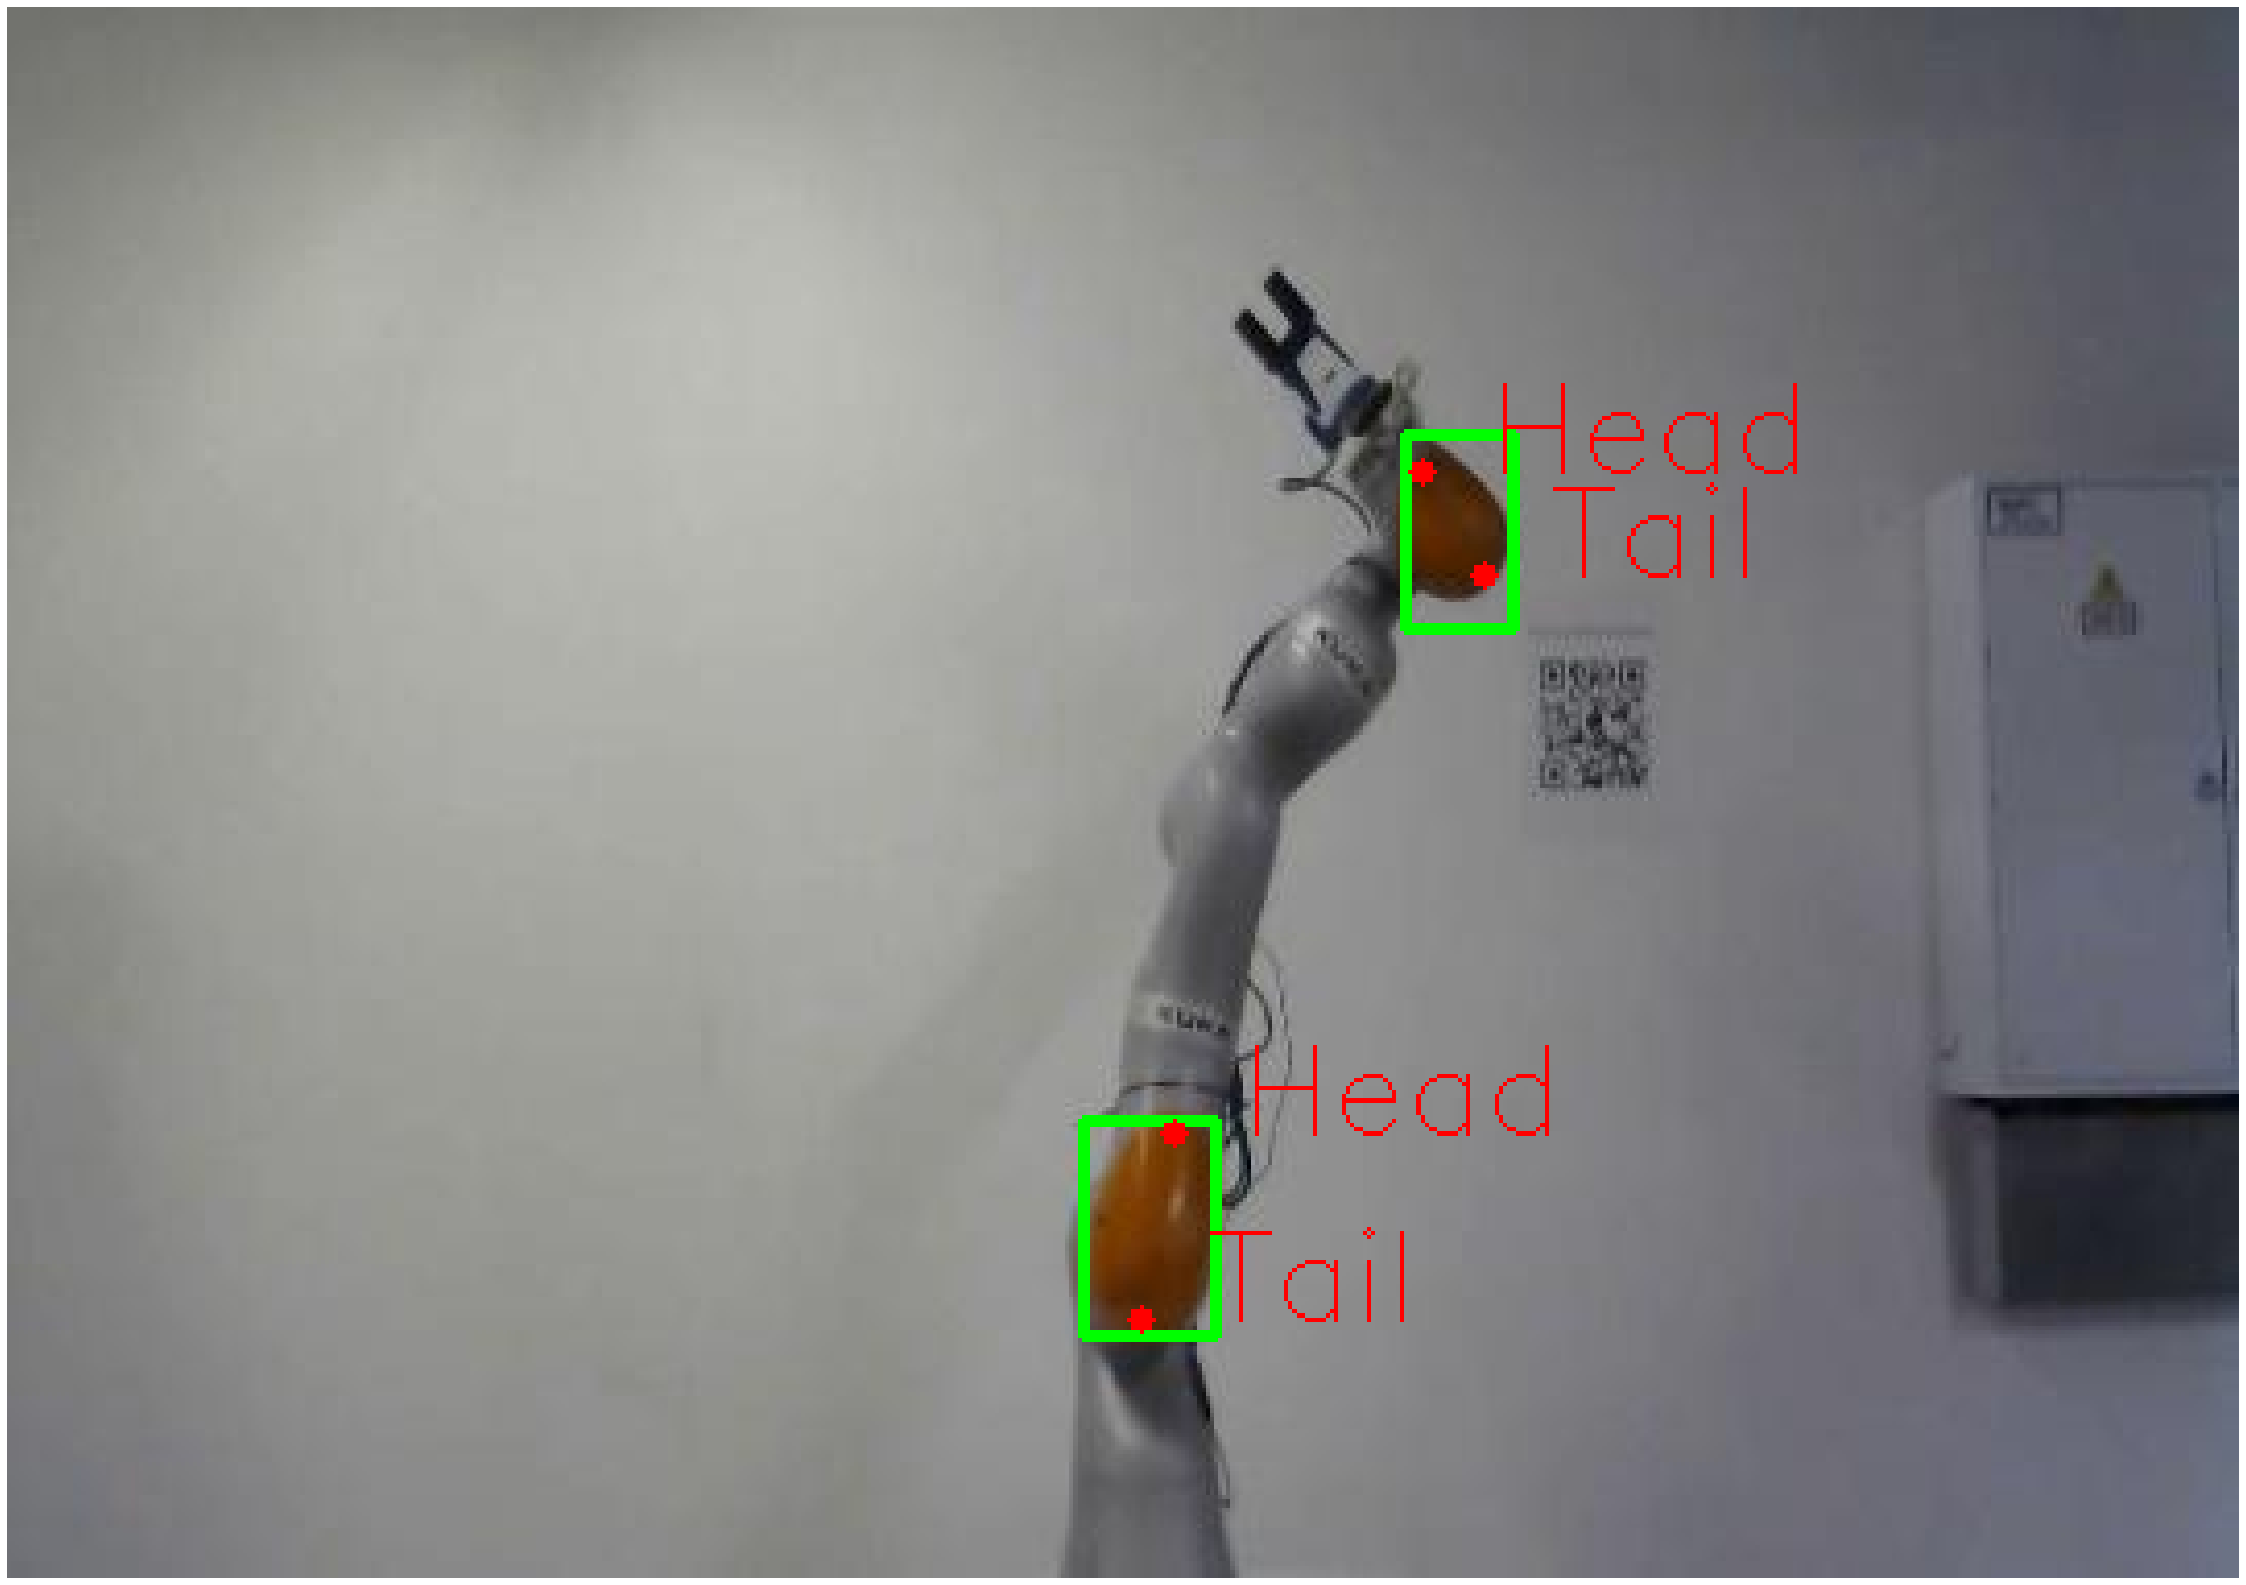

In [ ]:
# Take images from dataset
iterator = iter(data_loader_test)
for _ in range(7):
  images, targets = next(iterator)
images = list(image.to(device) for image in images)

# Generate predictions
with torch.no_grad():
    model.to(device)
    model.eval()
    output = model(images)

# Take one of predicted images
image3 = (images[0].permute(1,2,0).detach().cpu().numpy() * 255).astype(np.uint8)
# Get prediction scores
scores = output[0]['scores'].detach().cpu().numpy()

# Find indices of elements with score > 0.2
high_scores_idxs = np.where(scores > 0.2)[0].tolist()
# Find indicess of boxes after applying Non-Maximum Suppression (NMS)
post_nms_idxs = torchvision.ops.nms(output[0]['boxes'][high_scores_idxs], output[0]['scores'][high_scores_idxs], 0.1).cpu().numpy()

# Find bounding boxes using thresholed indices
bboxes = []
for bbox in output[0]['boxes'][high_scores_idxs][post_nms_idxs].detach().cpu().numpy():
    bboxes.append(list(map(int, bbox.tolist())))

# Find keypoints using thresholed indices
keypoints = []
for kps in output[0]['keypoints'][high_scores_idxs][post_nms_idxs].detach().cpu().numpy():
    keypoints.append([list(map(int, kp[:2])) for kp in kps])

# Call function to visualize result
visualize(image3, bboxes, keypoints)

## Use pretrained model

### Load pretrained model

In [ ]:
load_model = torch.load('/content/model.pt')
load_model.eval()

KeypointRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(640, 672, 704, 736, 768, 800), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, 

### Load images from dataset

In [ ]:
KEYPOINTS_FOLDER_TRAIN = '/content/train'
KEYPOINTS_FOLDER_TEST = '/content/test'

dataset_train = ClassDataset(KEYPOINTS_FOLDER_TRAIN, transform=train_transform(), demo=False)
dataset_test = ClassDataset(KEYPOINTS_FOLDER_TEST, transform=None, demo=False)

data_loader_train = DataLoader(dataset_train, batch_size=3, shuffle=True, collate_fn=collate_fn)
data_loader_test = DataLoader(dataset_test, batch_size=1, shuffle=False, collate_fn=collate_fn)

### Visualize result using pretrained model

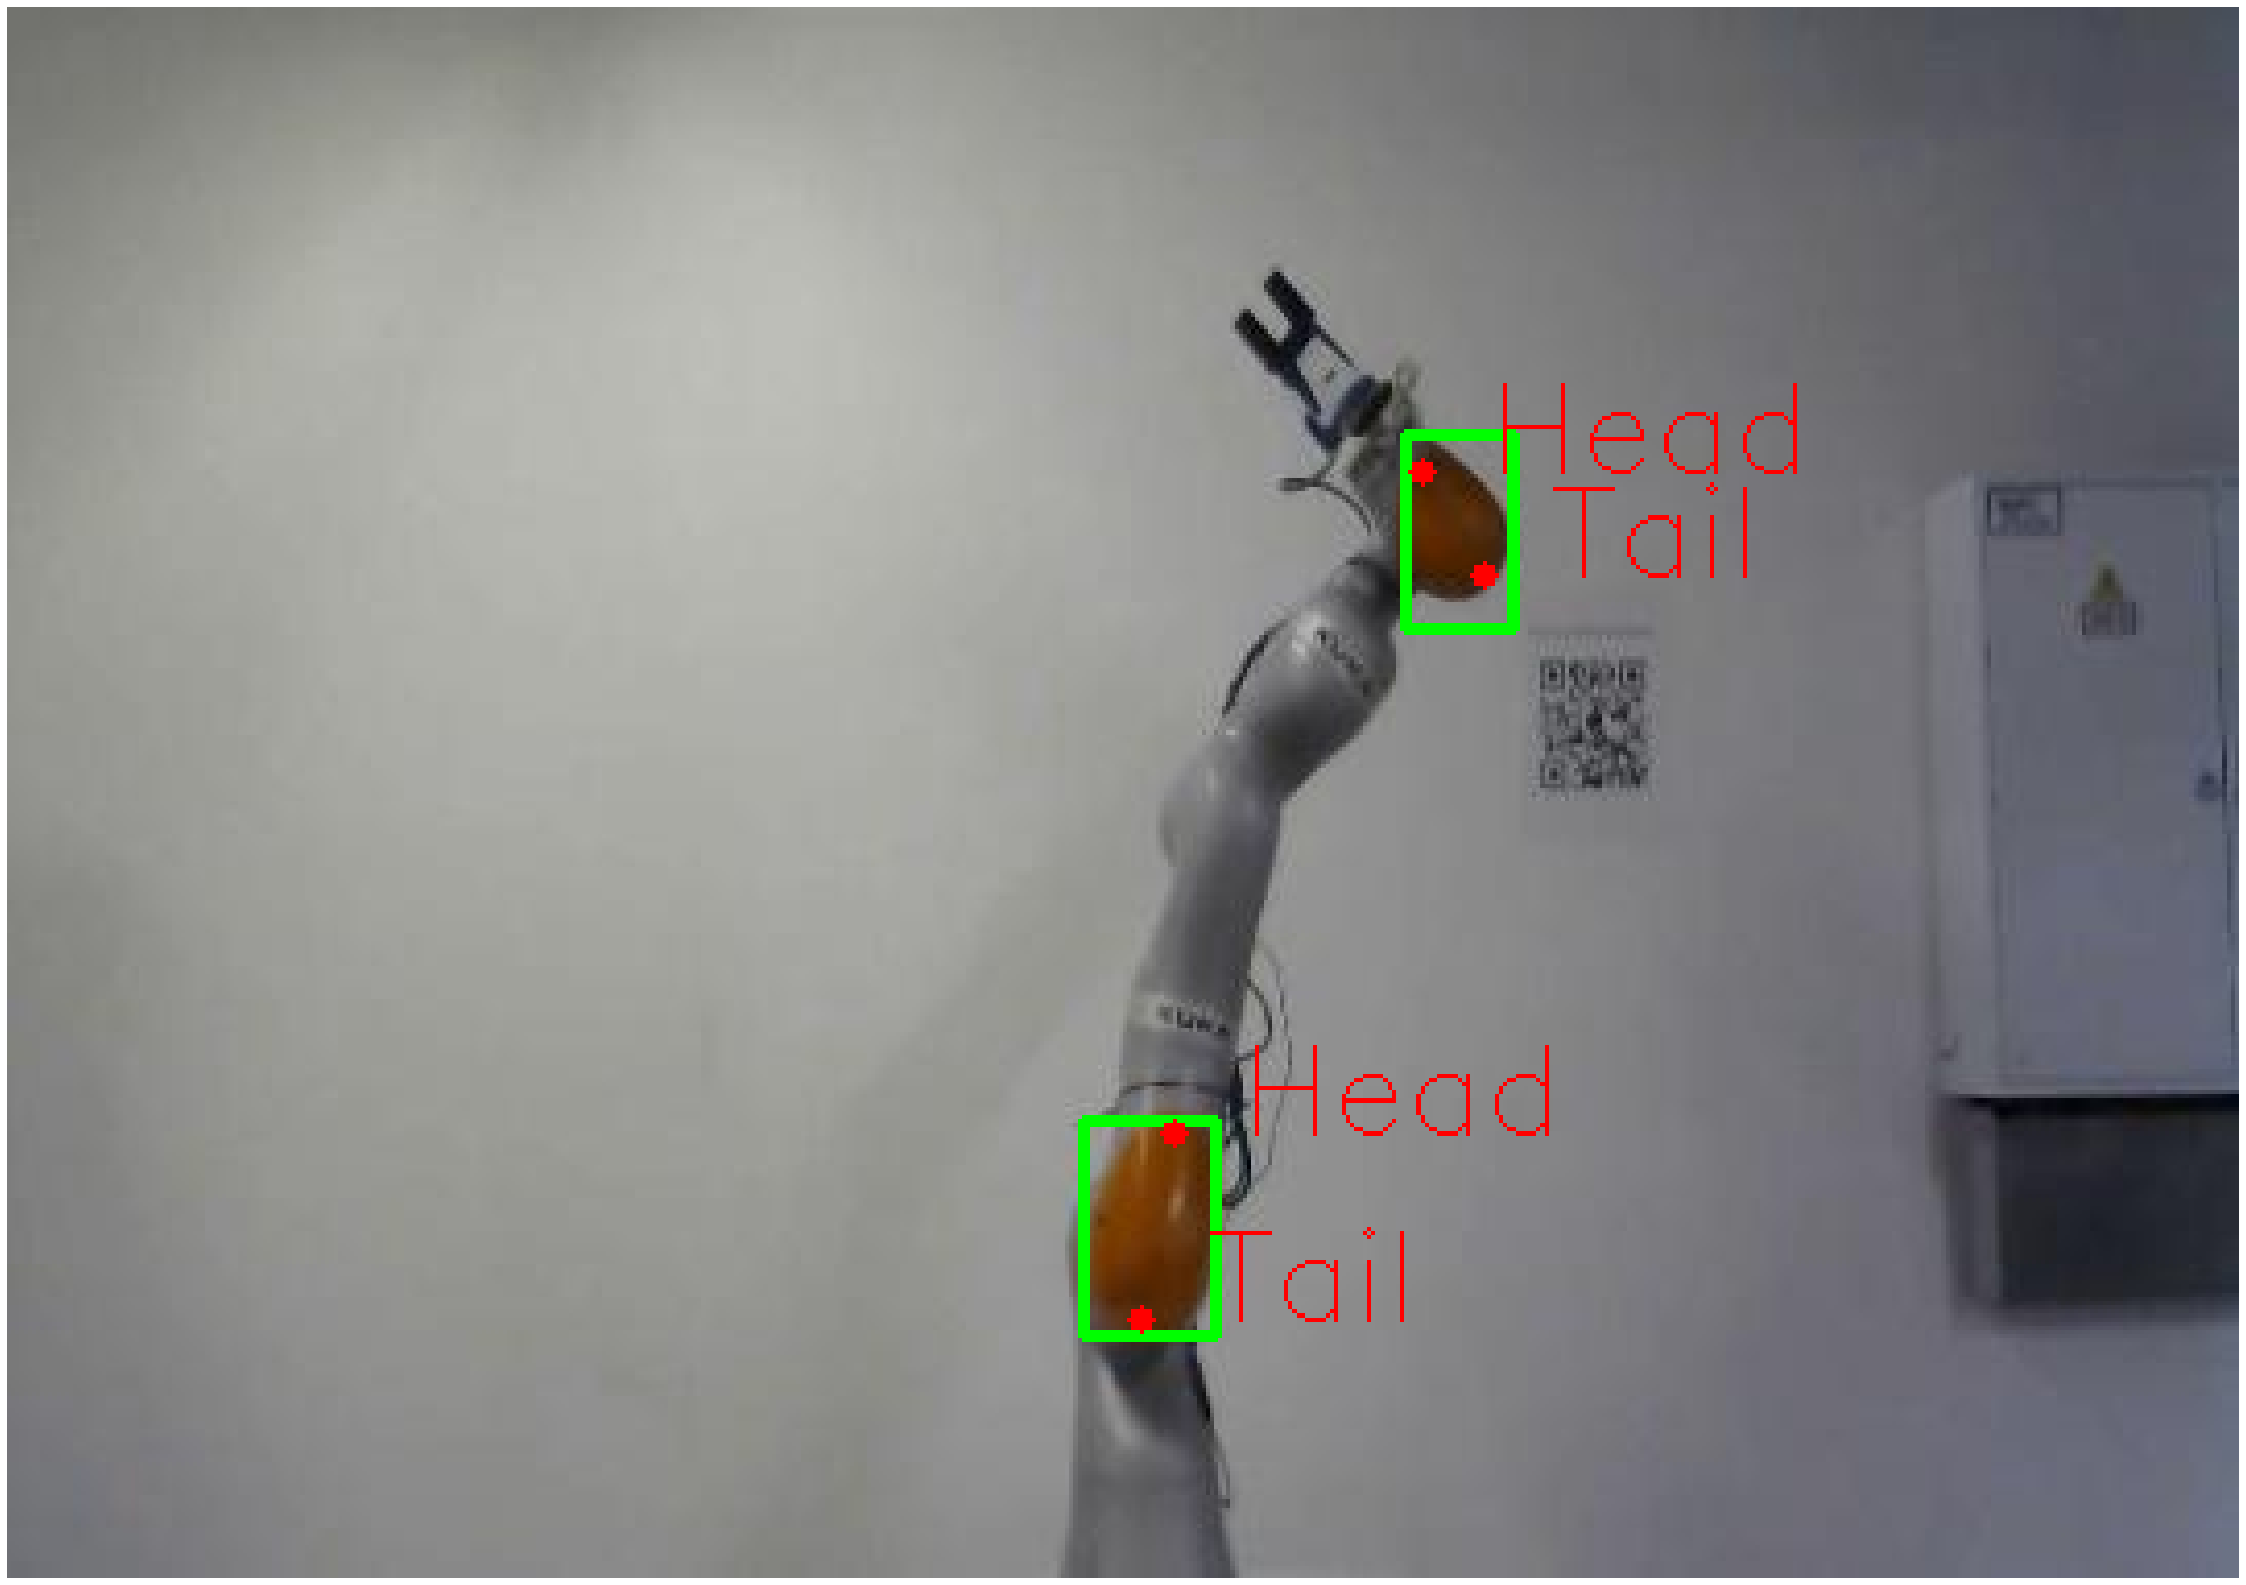

In [ ]:
# Take images from dataset
iterator = iter(data_loader_test)
for _ in range(7):
  images, targets = next(iterator)
images = list(image.to(device) for image in images)

# Generate predictions
with torch.no_grad():
    load_model.to(device)
    load_model.eval()
    output = load_model(images)

# Take one of predicted images
image3 = (images[0].permute(1,2,0).detach().cpu().numpy() * 255).astype(np.uint8)
# Get prediction scores
scores = output[0]['scores'].detach().cpu().numpy()

# Find indices of elements with score > 0.2
high_scores_idxs = np.where(scores > 0.2)[0].tolist()
# Find indicess of boxes after applying Non-Maximum Suppression (NMS)
post_nms_idxs = torchvision.ops.nms(output[0]['boxes'][high_scores_idxs], output[0]['scores'][high_scores_idxs], 0.1).cpu().numpy()

# Find bounding boxes using thresholed indices
bboxes = []
for bbox in output[0]['boxes'][high_scores_idxs][post_nms_idxs].detach().cpu().numpy():
    bboxes.append(list(map(int, bbox.tolist())))

# Find keypoints using thresholed indices
keypoints = []
for kps in output[0]['keypoints'][high_scores_idxs][post_nms_idxs].detach().cpu().numpy():
    keypoints.append([list(map(int, kp[:2])) for kp in kps])

# Call function to visualize result
visualize(image3, bboxes, keypoints)